ここでの目的は、高次元の空間でまとまっているインスタンスを識別することです。

このノートでは、教師なしの学習問題をグラフの最適化にマッピングする方法について説明します。

これを量子コンピュータで解くことができます。

クラスタリングから離散最適化へのマッピング ある高次元空間$ \mathbb {R} ^ d $の中にいくつかの点$ \{x_i \} _ {i = 1} ^ N $があるとします。どのものが互いに近く、どのものが離れているかをどうやって知ることができるか？

直感を得るために、2つの異なるクラスを持つ単純なデータセットを生成しましょう。

最初の2つのインスタンスはクラス1に属し、次の2つはクラス2に属します。


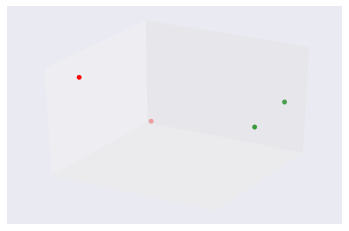

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

n_instances = 4 # 少ないけど、10に増やしただけでも計算に数時間かかる
class_1 = np.random.rand(n_instances//2, 3)/2
class_2 = (0.6, 0.1, 0.05) \
+ np.random.rand(n_instances//2, 3)/2
data = np.concatenate((class_1, class_2))
colors = ["red"] * (n_instances//2) \
+ ["green"] * (n_instances//2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xticks=[],\
yticks=[], zticks=[])
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors);

点が描画される。


　点間の距離をユークリッド距離でとります。この重み行列はグラム行列やカーネル行列と言われたりします。

In [2]:
import itertools
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data[i]-data[j])
w

array([[ 0.        ,  0.32071185,  0.60375194,  0.56706516],
       [ 0.32071185,  0.        ,  0.55518158,  0.52302135],
       [ 0.60375194,  0.55518158,  0.        ,  0.0694698 ],
       [ 0.56706516,  0.52302135,  0.0694698 ,  0.        ]])

クラスタを見つけるためにこの行列を使って何ができるでしょうか。max-cut、つまり削除するとグラフを2つに分割し、残ったエッジの合計の重みが最大になるエッジの集合を探すことができる。
　これはよく知られているNP困難な問題ですが、それは自然にイジングモデルを適応できる。

スピン $\sigma_i \in \{-1, +1\}$ $\sigma_i = +1$をとる。データインスタンスがクラスタ 1 (グラフのノード $V_1$ )、 $\sigma_i = -1$  (グラフのノード $V_2$)とする。

カットのコストは

$$
\sum_{i\in V_1, j\in V_2} w_{ij}
$$

完全に接続されたグラフを仮定しましょう。次に、重み行列の対称性を考慮して、これを次のように展開できます。
$$
\frac{1}{4}\sum_{i, j} w_{ij} - \frac{1}{4} \sum_{i, j} w_{ij} \sigma_i \sigma_j
$$
$$
= \frac{1}{4}\sum_{i, j\in V} w_{ij} (1- \sigma_i \sigma_j).
$$                 

これの負をとり、問題を解決することができます。

# Solving the max-cut problem by QAOA

QAOAはいろんなフレームワークで提供されています。

In [0]:
from qiskit_aqua import get_aer_backend, QuantumInstance
from qiskit_aqua.algorithms import QAOA
from qiskit_aqua.components.optimizers import COBYLA
from qiskit_aqua.translators.ising import maxcut

Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

In [0]:
qubit_operators, offset = maxcut.get_maxcut_qubitops(w) # 重み行列から、グラフの最大カット問題に対するハミルトニアンを生成
p = 1
optimizer = COBYLA() # 最適化に使うオプティマイザ
qaoa = QAOA(qubit_operators, optimizer,\
p, operator_mode='matrix')

 COBYLAは他の古典的なオプティマイザでも大丈夫です。
 
 これを実行して解を分析しましょう。これは古典的なシミュレータではしばらく時間がかかることがあります。

In [8]:
backend = get_aer_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=100)
result = qaoa.run(quantum_instance) 
# QAOAを走らせる
x = maxcut.sample_most_likely(result['eigvecs'][0]) 
# QAOAを走らせた結果の固有ベクトルをxに代入
graph_solution = maxcut.get_graph_solution(x) 
print('energy:', result['energy'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, w))

energy: -0.421689928845
maxcut objective: -1.74129077092
solution: [ 0.  0.  1.  1.]
solution objective: 2.24902003393


解を見ると、前の2つ、後ろの2つが同じになっており、カットはクラスタリング構造と一致しています。

BlueqatのQAOAでも解いてみましょう。

In [10]:
!pip install blueqat
from blueqat import opt, vqe
from blueqat.pauli import qubo_bit as q

hamiltonian = w[0][1]*q(0)*q(1) + w[0][2]*q(0)*q(2)\
+ w[0][3]*q(0)*q(3) + w[1][2]*q(1)*q(2) \
+ w[1][3]*q(1)*q(3) + w[2][3]*q(2)*q(3)
hamiltonian = hamiltonian[0][1]
step = 30

result=vqe.Vqe(vqe.QaoaAnsatz(hamiltonian, step)).run()
print(result.most_common(5))

    100% |████████████████████████████████| 31.2MB 303kB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.13.3 which is incompatible.
fastai 1.0.51 has requirement numpy>=1.15, but you'll have numpy 1.13.3 which is incompatible.
cvxpy 1.0.15 has requirement numpy>=1.14, but you'll have numpy 1.13.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:
      Successfully uninstalled scipy-1.2.1


(((1, 1, 0, 0), 0.4930979267662185), ((0, 0, 1, 1), 0.4930979267662185), ((1, 1, 1, 0), 0.0029934456413002143), ((0, 0, 0, 1), 0.0029934456413002143), ((1, 0, 0, 0), 0.0019161280723559468))


# References

[1] Otterbach, J. S., Manenti, R., Alidoust, N., Bestwick, A., Block, M., Bloom, B., Caldwell, S., Didier, N., Fried, E. Schuyler, Hong, S., Karalekas, P., Osborn, C. B., Papageorge, A., Peterson, E. C., Prawiroatmodjo, G., Rubin, N., Ryan, Colm A., Scarabelli, D., Scheer, M., Sete, E. A., Sivarajah, P., Smith, Robert S., Staley, A., Tezak, N., Zeng, W. J., Hudson, A., Johnson, Blake R., Reagor, M., Silva, M. P. da, Rigetti, C. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*. <a id='1'></a>